# Distributed Image Processing in the Cloud 

## Learning objectives

- Become familiar with **lazy, distributed Python image processing** with Dask
- Learn how to start and interact with a **Coiled.io cloud cluster**
- Understand why **consistent software environments** are required and how to create them

In [ ]:
# Install package dependencies
import sys

!{sys.executable} -m pip install --upgrade --pre zarr multiscale-spatial-image matplotlib itk-io tifffile itkwidgets ome-zarr dask coiled distributed graphviz

## Distributed Python Image Processing with Dask

![Dask overview](https://docs.dask.org/en/latest/_images/dask-overview.svg)

[Dask](https://dask.org/) is *a Python-based, flexible library for parallel computing*. Dask provides dynamic task scheduling optimized for interactive computing, and parallel-friendly collections such as the `dask.array`.

Dask can run tasks in parallel on a single machine via threads or processes. Or, the same code can trivially also be executed on a collection of local workstations connected via SSH, or an [HPC cluster with a traditional job scheduler](https://docs.dask.org/en/latest/setup/hpc.html), or a managed Kubernetes-based cloud cluster.

In [1]:
import dask.array as da
from datatree import open_datatree
from multiscale_spatial_image import to_multiscale
import zarr
from itkwidgets import view
import time
import coiled
from dask.distributed import Client, LocalCluster

## Load Zarr

Load the OME-NGFF Zarr image array from the previous tutorial

In [2]:
image_name = 'HL50_cell'
image_path = 'HL50_cell.zarr'

arr = da.from_zarr(f'{image_path}/scale0/HL50_cell')
arr

dask.array<from-zarr, shape=(129, 212, 363), dtype=uint16, chunksize=(64, 64, 64), chunktype=numpy.ndarray>

Load the entire OME-NGFF multiscale image, including metadata.

In [3]:
multiscale = open_datatree(image_path, engine='zarr', mode='r', consolidated=False)
multiscale

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       multiscales:  [{'@type': 'ngff:Image', 'axes': [{'name': 'x', 'type': 'sp...
├── DataTree('scale0')
│       Dimensions:    (z: 129, y: 212, x: 363)
│       Coordinates:
│         * x          (x) float64 0.0 1.0 2.0 3.0 4.0 ... 358.0 359.0 360.0 361.0 362.0
│         * y          (y) float64 0.0 1.0 2.0 3.0 4.0 ... 207.0 208.0 209.0 210.0 211.0
│         * z          (z) float64 0.0 1.0 2.0 3.0 4.0 ... 124.0 125.0 126.0 127.0 128.0
│       Data variables:
│           HL50_cell  (z, y, x) uint16 ...
│       Attributes:
│           Software:   InsightToolkit
│           direction:  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
├── DataTree('scale1')
│       Dimensions:    (z: 64, y: 106, x: 181)
│       Coordinates:
│         * x          (x) float64 1.5 3.5 5.5 7.5 9.5 ... 353.5 355.5 357.5 359.5 361.5
│         * y          (y) float64 0.5 2.5 4.5 6.5 8.5 ... 202.5 204.5 206.5 208.5 210.5
│         * z          (z) float64 1.5 3.5 5.5 7.5 9.5 ... 119.5 121.5 123.5 125.5 127.5
│       Data variables:
│           HL50_cell  (z, y, x) uint16 ...
│       Attributes:
│           Software:   InsightToolkit
│           direction:  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
└── DataTree('scale2')
        Dimensions:    (z: 16, y: 26, x: 45)
        Coordinates:
          * x          (x) float64 6.5 14.5 22.5 30.5 38.5 ... 334.5 342.5 350.5 358.5
          * y          (y) float64 7.5 15.5 23.5 31.5 39.5 ... 183.5 191.5 199.5 207.5
          * z          (z) float64 4.5 12.5 20.5 28.5 36.5 ... 100.5 108.5 116.5 124.5
        Data variables:
            HL50_cell  (z, y, x) uint16 ...
        Attributes:
            Software:   InsightToolkit
            direction:  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

In [4]:
view(multiscale['scale1'].ds.HL50_cell, gradient_opacity=0.2)

Viewer(geometries=[], point_sets=[], rendered_image=<itk.itkImagePython.itkImageUS3; proxy of <Swig Object of …

## Generate a task graph

Let's regenerate the multiscale representation with more scales.

In [5]:
scaley = to_multiscale(multiscale['scale0'].ds.HL50_cell, [2,3,4])
scaley

DataTree('None', parent=None)
├── DataTree('scale0')
│       Dimensions:    (x: 363, y: 212, z: 129)
│       Coordinates:
│         * x          (x) float64 0.0 1.0 2.0 3.0 4.0 ... 358.0 359.0 360.0 361.0 362.0
│         * y          (y) float64 0.0 1.0 2.0 3.0 4.0 ... 207.0 208.0 209.0 210.0 211.0
│         * z          (z) float64 0.0 1.0 2.0 3.0 4.0 ... 124.0 125.0 126.0 127.0 128.0
│       Data variables:
│           HL50_cell  (z, y, x) uint16 dask.array<chunksize=(64, 64, 64), meta=np.ndarray>
│       Attributes:
│           Software:   InsightToolkit
│           direction:  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
├── DataTree('scale1')
│       Dimensions:    (x: 181, y: 106, z: 64)
│       Coordinates:
│         * x          (x) float64 1.5 3.5 5.5 7.5 9.5 ... 353.5 355.5 357.5 359.5 361.5
│         * y          (y) float64 0.5 2.5 4.5 6.5 8.5 ... 202.5 204.5 206.5 208.5 210.5
│         * z          (z) float64 1.5 3.5 5.5 7.5 9.5 ... 119.5 121.5 123.5 125.5 127.5
│       Data variables:
│           HL50_cell  (z, y, x) uint16 dask.array<chunksize=(64, 64, 64), meta=np.ndarray>
│       Attributes:
│           Software:   InsightToolkit
│           direction:  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
├── DataTree('scale2')
│       Dimensions:    (x: 60, y: 35, z: 21)
│       Coordinates:
│         * x          (x) float64 5.5 11.5 17.5 23.5 29.5 ... 341.5 347.5 353.5 359.5
│         * y          (y) float64 4.5 10.5 16.5 22.5 28.5 ... 190.5 196.5 202.5 208.5
│         * z          (z) float64 5.5 11.5 17.5 23.5 29.5 ... 107.5 113.5 119.5 125.5
│       Data variables:
│           HL50_cell  (z, y, x) uint16 dask.array<chunksize=(21, 35, 60), meta=np.ndarray>
│       Attributes:
│           Software:   InsightToolkit
│           direction:  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
└── DataTree('scale3')
        Dimensions:    (x: 15, y: 8, z: 5)
        Coordinates:
          * x          (x) float64 14.5 38.5 62.5 86.5 110.5 ... 278.5 302.5 326.5 350.5
          * y          (y) float64 31.5 55.5 79.5 103.5 127.5 151.5 175.5 199.5
          * z          (z) float64 20.5 44.5 68.5 92.5 116.5
        Data variables:
            HL50_cell  (z, y, x) uint16 dask.array<chunksize=(5, 8, 15), meta=np.ndarray>
        Attributes:
            Software:   InsightToolkit
            direction:  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

In [6]:
scaley['scale1'].ds.HL50_cell

<xarray.DataArray 'HL50_cell' (z: 64, y: 106, x: 181)>
dask.array<rechunk-merge, shape=(64, 106, 181), dtype=uint16, chunksize=(64, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 1.5 3.5 5.5 7.5 9.5 ... 353.5 355.5 357.5 359.5 361.5
  * y        (y) float64 0.5 2.5 4.5 6.5 8.5 ... 202.5 204.5 206.5 208.5 210.5
  * z        (z) float64 1.5 3.5 5.5 7.5 9.5 ... 119.5 121.5 123.5 125.5 127.5
Attributes:
    Software:   InsightToolkit
    direction:  [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

The `dask.Array` pixel data is stored as the `data` attribute of the xarray DataArray.

In [7]:
scaley['scale1'].ds.HL50_cell.data

dask.array<rechunk-merge, shape=(64, 106, 181), dtype=uint16, chunksize=(64, 64, 64), chunktype=numpy.ndarray>

The operations to generate the array are not executed eagerly.

Dask creates a task graph based on the operations in the functions and the chunks in the array.

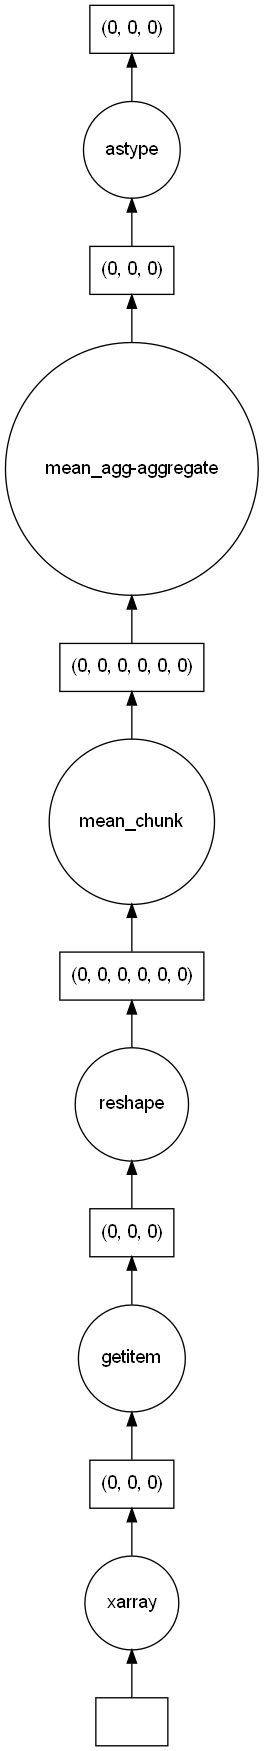

In [8]:
small_scaley = to_multiscale(multiscale['scale2'].ds.HL50_cell, [2])
small_scaley['scale1'].ds.HL50_cell.data.visualize()

## Execute the task graph

Computation is lazy by default -- we can trigger it with and return the result with `.compute()` or compute and persist the result in memory with `.persist()`.

In [9]:
start = time.time()

# Computation is executed
scaley = scaley.persist()

elapsed = time.time() - start
print(elapsed, 'seconds')

0.45862913131713867 seconds


In [10]:
start = time.time()

# Computation has already executed
scaley = scaley.persist()

elapsed = time.time() - start
print(elapsed, 'seconds')

0.002997875213623047 seconds


## Execute the graph on a local cluster

In [11]:
# Start a new local cluster
cluster = LocalCluster(n_workers=4)
client = Client(cluster)
# Click on the *Dashboard* link
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58378,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.86 GiB
Comm: tcp://127.0.0.1:58418,Total threads: 4
Dashboard: http://127.0.0.1:58419/status,Memory: 7.96 GiB
Nanny: tcp://127.0.0.1:58382,


Execute again, but on the LocalCluster

In [12]:
scaley = to_multiscale(multiscale['scale0'].ds.HL50_cell, [2,3,4])

start = time.time()

# Computation has already executed
scaley = scaley.persist()

elapsed = time.time() - start
print(elapsed, 'seconds')

0.7063391208648682 seconds


## Execute the graph on a cloud cluster

[Coiled.io](https://coiled.io/) is a service that provides a dynamic cloud cluster with minimal configuration.

In [14]:
#ciskip
# Start a new cloud cluster
# Before starting Jupyter, login on the command line with:
#
#  $ coiled login

# Shutdown our local cluster
cluster.close()

# Set to re-use a running cluster when re-running the notebook. Listed at https://cloud.coiled.io/<username>/clusters.
name = None
cluster = coiled.Cluster(n_workers=4,
                         worker_cpu=2,
                         worker_memory='6G',
                         name=name,
                         software='thewtex/i2k-web-2022')
    
client = Client(cluster)
# Click on the *Dashboard* link
client

Output()

Connection method: Cluster object,Cluster type: coiled.ClusterBeta
Dashboard: http://35.175.125.57:8787,
Dashboard: http://35.175.125.57:8787,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tls://172.18.0.2:8786,Workers: 0
Dashboard: http://172.18.0.2:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


*Note:*

It is **critical** that the:

- Jupyter client
- Jupyter kernel
- Dask scheduler
- Dask workers

all have a consistent software environment.

See [the coiled documentation on how to create a consistent software environment](https://docs.coiled.io/user_guide/software_environment.html).

In [15]:
%pycat ./create_coiled_software_environment.py

In [15]:
# Run on the cloud cluster -- keep an eye on the dashboard!
scaley = to_multiscale(multiscale['scale0'].ds.HL50_cell, [2,3,4])

start = time.time()

scaley = scaley.persist()

elapsed = time.time() - start
print(elapsed, 'seconds')

0.14321374893188477 seconds


## Osteoarthritis Initiative (OAI) Analysis on the Coiled Cloud 

End-to-end processing pipeline performing segmentation, registration, and mesh analysis to quantify cartilage thickness from knee osteoarthritis images. [Slides](https://docs.google.com/presentation/d/1sT7zOM2H_e-n4ogfOdj0WldlGwtxNpC8wiinD-gDYkc/edit#slide=id.g126532834ca_0_184)

## Exercises

### Exercise 1

Change the number of local workers.

*How does the number of workers impact downsampling performance?*

In [16]:
# Shutdown the old custer
cluster.close()

cluster = LocalCluster(n_workers=2)
client = Client(cluster)
client

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58501 instead


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:58501/status,
Dashboard: http://127.0.0.1:58501/status,Workers: 2
Total threads: 16,Total memory: 31.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58502,Workers: 2
Dashboard: http://127.0.0.1:58501/status,Total threads: 16
Started: Just now,Total memory: 31.86 GiB
Comm: tcp://127.0.0.1:58519,Total threads: 8
Dashboard: http://127.0.0.1:58520/status,Memory: 15.93 GiB
Nanny: tcp://127.0.0.1:58505,


In [17]:
scaley = to_multiscale(multiscale['scale0'].ds.HL50_cell, [2,3,4])

start = time.time()

scaley = scaley.persist()

elapsed = time.time() - start
print(elapsed, 'seconds')

0.14162588119506836 seconds


2022-05-09 14:52:53,045 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


### Exercise 2

*Reproduce the OAI analysis on the Coiled Cloud*

<a href="https://colab.research.google.com/github/uncbiag/OAI_analysis_2/blob/master/notebooks/DaskComputationCoiled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>